# Reading Reddit Comments For Superbowl

In [168]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import datetime as dt

import requests
import numpy as np
import pandas as pd

%matplotlib inline

In [68]:
##### Pull first 500 comments and get last comment's UTC
json = requests.get("https://api.pushshift.io/reddit/comment/search?link_id=5sapal&limit=500&sort=desc", headers={'User-Agent': "AUniqueUserAgent"})
comments = json.json()['data']
df = pd.DataFrame(comments)

#Pull Next 500 Comments

for x in range(0,500):
    last_uct = comments[-1]['created_utc']
    json = requests.get("https://api.pushshift.io/reddit/comment/search?link_id=5sapal&limit=500&sort=desc&before={}".format(last_uct), headers={'User-Agent': "AUniqueUserAgent"})
    comments = json.json()['data']
    df2 = pd.DataFrame(comments)
    df = pd.concat([df, df2])
    try:
        print('=========Last comment pulled: {}'.format(comments[-1]['body']))
    except IndexError:
        print('No More Comments to pull')
        break
    print('Timestamp: {}'.format(comments[-1]['created_utc']))
    print('Number of comments pulled {}'.format(df.shape[0]))

=========Last comment pulled: If Bennet hadn't caught it, it probably would have been an INT.
Timestamp: 1486361483
Number of comments pulled 1000
=========Last comment pulled: Haha cuz TB.  I get it.
Timestamp: 1486356246
Number of comments pulled 1500
=========Last comment pulled: The man who was crying in the first quarter after that interception? 
Timestamp: 1486354803
Number of comments pulled 2000
=========Last comment pulled: We know what you said, there is no misunderstanding,   we all just think it's tremendously dumb.
Timestamp: 1486353929
Number of comments pulled 2500
=========Last comment pulled: Brady is GOAT. 
Timestamp: 1486353299
Number of comments pulled 3000
=========Last comment pulled: He was a little more contained than last time.  
Timestamp: 1486352897
Number of comments pulled 3500
=========Last comment pulled: I really don't like this "give the trophy to the owner" thing. Just doesn't feel right.
Timestamp: 1486352626
Number of comments pulled 4000
=========La

=========Last comment pulled: Too soon man
Timestamp: 1486349084
Number of comments pulled 32500
=========Last comment pulled: Thanks pats for making the game interesting again. might just have a ball game on our hands
Timestamp: 1486349021
Number of comments pulled 33000
=========Last comment pulled: For anyone struggling with the stream, the spanish version is still up.

https://www.foxsportsgo.com/event/156823/super-bowl-li-en-espaol-patriots-v-falcons
Timestamp: 1486348967
Number of comments pulled 33500
=========Last comment pulled: Goooooaaaaaallllll
Timestamp: 1486348910
Number of comments pulled 34000
=========Last comment pulled: Yeah, I've got the logo like it's an ad break. Been that way for about 10 minutes. 
Timestamp: 1486348820
Number of comments pulled 34500
=========Last comment pulled: I don't think there is, I haven't heard the buzz about it. They usually try to sneak in some hints 
Timestamp: 1486348741
Number of comments pulled 35000
=========Last comment pulled: I

=========Last comment pulled: Welp time to play some Madden
Timestamp: 1486343642
Number of comments pulled 64000
=========Last comment pulled: Alpha Romeo half time show where I am. 
Timestamp: 1486343523
Number of comments pulled 64500
=========Last comment pulled: I fucking hope not, I watch football to avoid real life shit
Timestamp: 1486343429
Number of comments pulled 65000
=========Last comment pulled: dan quinn was coaching in both of those games
Timestamp: 1486343301
Number of comments pulled 65500
=========Last comment pulled: [removed]
Timestamp: 1486343190
Number of comments pulled 66000
=========Last comment pulled: Alternate views. 
Timestamp: 1486343101
Number of comments pulled 66500
=========Last comment pulled: What the hell was that play call
Timestamp: 1486343014
Number of comments pulled 67000
=========Last comment pulled: Perfect night for it to not be their night
Timestamp: 1486342932
Number of comments pulled 67500
=========Last comment pulled: They got it
Times

=========Last comment pulled: Is the fox steam showing the commercials? 
Timestamp: 1486338513
Number of comments pulled 95500
=========Last comment pulled: Yep 
Timestamp: 1486338419
Number of comments pulled 96000
=========Last comment pulled: Damn stuffed
Timestamp: 1486338291
Number of comments pulled 96500
=========Last comment pulled: You just gotta be blunt about it
Timestamp: 1486338136
Number of comments pulled 97000
=========Last comment pulled: Time outs?
Timestamp: 1486338028
Number of comments pulled 97500
=========Last comment pulled: coin flop
Timestamp: 1486337895
Number of comments pulled 98000
=========Last comment pulled: Tails 
Timestamp: 1486337760
Number of comments pulled 98500
=========Last comment pulled: Tear in me eye
Timestamp: 1486337604
Number of comments pulled 99000
=========Last comment pulled: I got wings and guacamole. Let's do this shit!
Timestamp: 1486337449
Number of comments pulled 99288


IndexError: list index out of range

In [78]:
# Save Copy of results
df.to_pickle('Superbowl_2017_Reddit_Comments.pkl')

# Make Mini DF with only import columns
df_small = df[['created_utc','author','author_flair_text','id','parent_id','body']]
df_small['count'] = 1 # For aggregation


flair = df_small.groupby('author_flair_text').aggregate(np.sum) # For counts by flair type

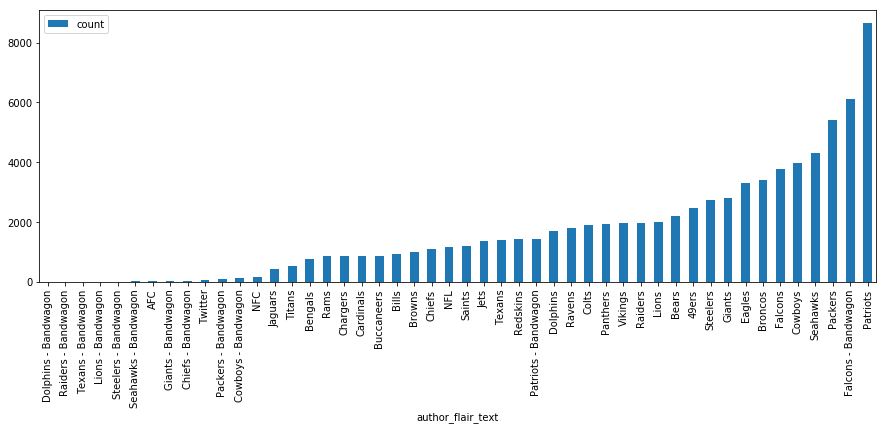

In [100]:
flair.sort_values('count').plot(y='count',kind='bar', figsize=(15,5))

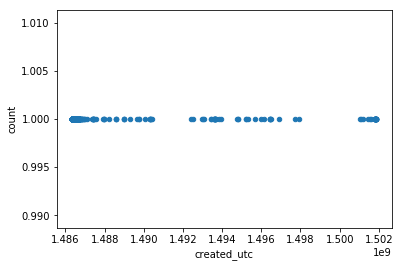

In [103]:
df_small.plot(x='created_utc',y='count', kind='scatter', jitter)

In [124]:
df_small = df_small.set_index('created_utc')

In [131]:
df_small['created_utc'] = df_small.index

In [135]:
df_small['datetime'] = df_small['created_utc'].apply(lambda x: dt.datetime.fromtimestamp(x))

In [147]:
#df_small = df_small.set_index('datetime')
df_small.reset_index(inplace=True)

# Compute VADER Sentiment

In [157]:
comments = df_small.body.tolist()

In [160]:
comments[505]

'brady isnt a family hating bitch like rodgers so he actually came back. we just passed you in super bowls. cyaaaaaaaaaaaaaaaaaa'

In [169]:
sid = SentimentIntensityAnalyzer()

def calculate_VADER(comment):
    comment = str(comment)
    ss = sid.polarity_scores(comment)
    neg = ss['neg']
    neu = ss['neu']
    pos = ss['pos']
    compound = ss['compound']
    return ss, neg, neu, pos, compound

In [177]:
df_small['ss'], df_small['neg'], df_small['neu'], df_small['pos'], df_small['compound'] = \
    zip(*df_small['body'].map(calculate_VADER))

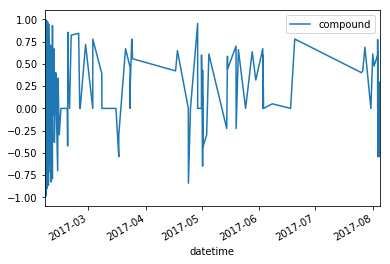

In [181]:
df_small.plot(x='datetime', y='compound')

In [187]:
df_gametime = df_small.loc[(df_small['datetime'] > '2017-02-05 18:30:49') & (df_small['datetime'] < '2017-02-05 23:00:00')]

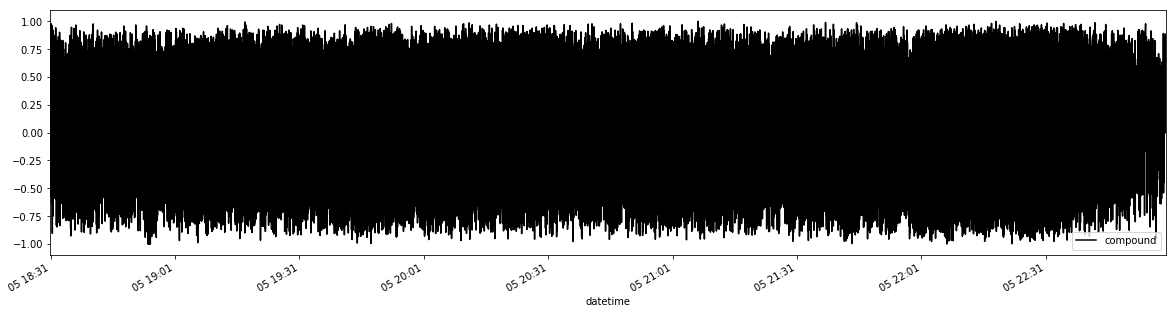

In [196]:
df_gametime.plot(x='datetime', y='compound', figsize=(20,5), color='black')

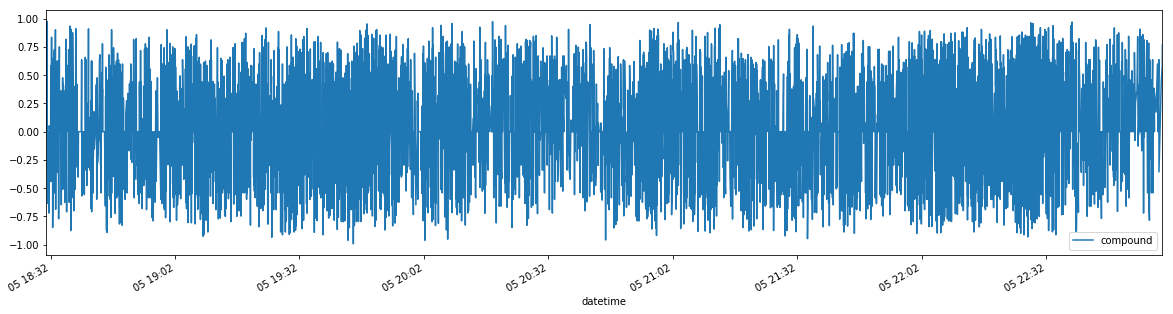

In [193]:
# Only Patriots Fans
df_pats_only = df_gametime.loc[df_gametime['author_flair_text'] == 'Patriots']
df_pats_only.plot(x='datetime', y='compound', figsize=(20,5))

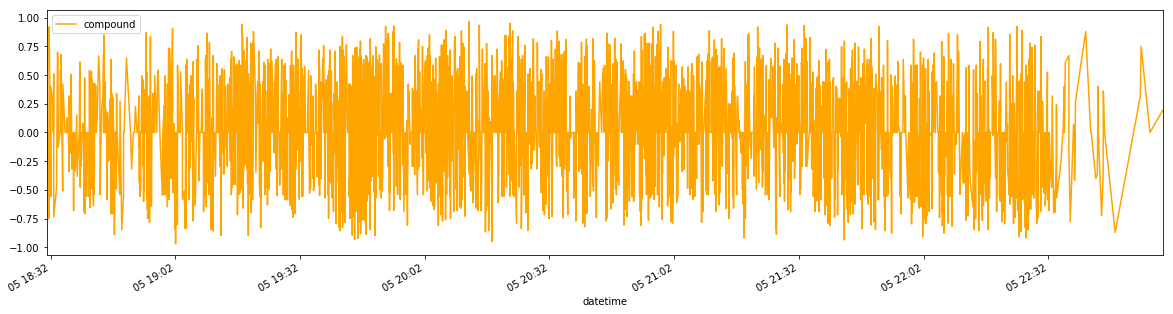

In [195]:
# Only Patriots Fans
df_falcons_only = df_gametime.loc[df_gametime['author_flair_text'] == 'Falcons']
df_falcons_only.plot(x='datetime', y='compound', figsize=(20,5), color='orange')

## Plot Sentiment Rolling Mean

/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=500,center=False).mean()
  """Entry point for launching an IPython kernel.
/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


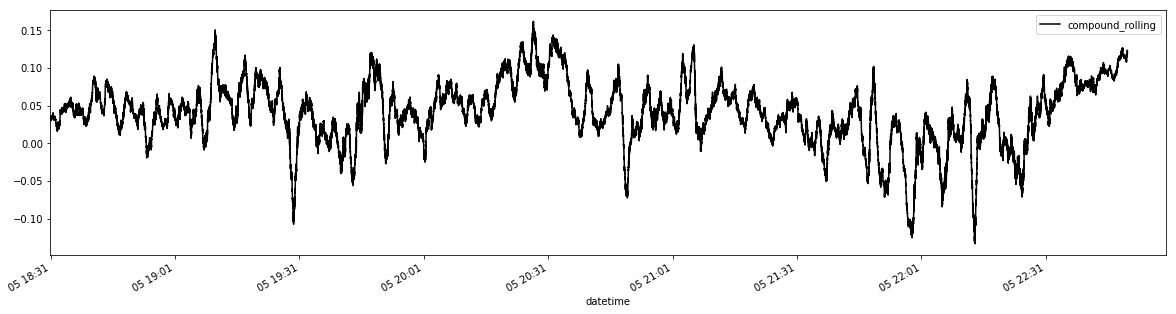

In [202]:
df_gametime['compound_rolling'] = pd.rolling_mean(df_gametime['compound'], window=500)
df_gametime.plot(x='datetime', y='compound_rolling', figsize=(20,5), color='black')

/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).mean()
  """
/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


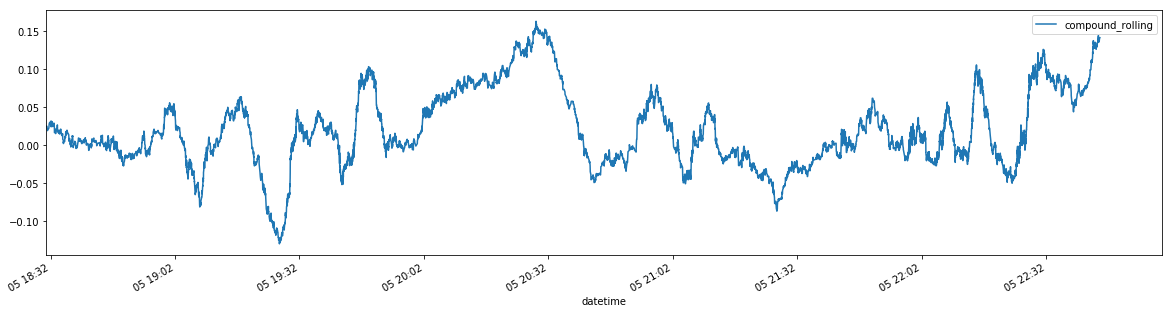

In [207]:
# Only Patriots Fans
df_pats_only = df_gametime.loc[df_gametime['author_flair_text'] == 'Patriots']
#df_pats_only.plot(x='datetime', y='compound', figsize=(20,5))

df_pats_only['compound_rolling'] = pd.rolling_mean(df_pats_only['compound'], window=200)
df_pats_only.plot(x='datetime', y='compound_rolling', figsize=(20,5))

/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).mean()
  """
/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


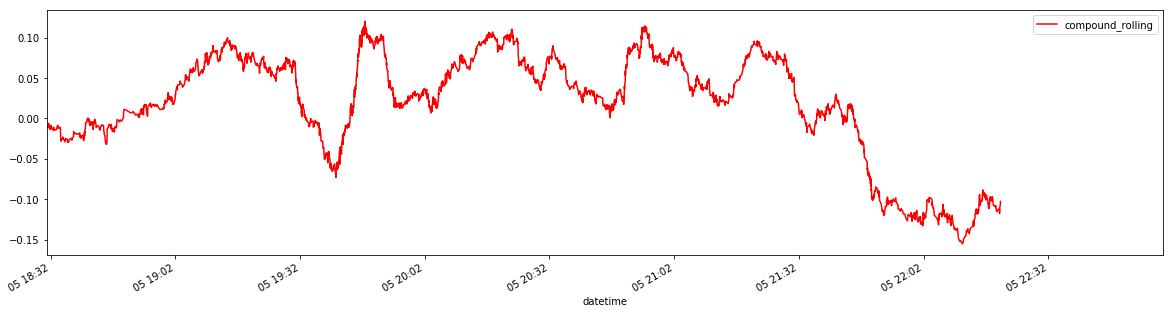

In [222]:
# Only Falcons Fans
df_falc_only = df_gametime.loc[df_gametime['author_flair_text'] == 'Falcons']
#df_pats_only.plot(x='datetime', y='compound', figsize=(20,5))

df_falc_only['compound_rolling'] = pd.rolling_mean(df_falc_only['compound'], window=200)
df_falc_only.plot(x='datetime', y='compound_rolling', figsize=(20,5), color='red')

In [214]:
df_gametime['author_flair_text'].unique()

array([None, 'Patriots', 'Broncos', 'Bears', 'Cowboys - Bandwagon',
       'Vikings', 'Colts', '49ers', 'Saints', 'Steelers',
       'Patriots - Bandwagon', 'Falcons', 'Packers', 'Seahawks', 'Jets',
       'Eagles', 'Rams', 'Falcons - Bandwagon', 'Chiefs', 'Cardinals',
       'Lions', 'Cowboys', 'Bengals', 'Raiders', 'Giants', 'Redskins',
       'Buccaneers', 'Panthers', 'Browns', 'Dolphins', 'Jaguars', 'NFL',
       'Titans', 'Chargers', 'Ravens', 'Texans', 'Bills', 'Twitter',
       'Packers - Bandwagon', 'NFC', 'AFC', 'Raiders - Bandwagon',
       'Seahawks - Bandwagon', 'Chiefs - Bandwagon',
       'Steelers - Bandwagon', 'Lions - Bandwagon', 'Giants - Bandwagon',
       'Dolphins - Bandwagon', 'Texans - Bandwagon'], dtype=object)

/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=200,center=False).mean()
  """
/Users/robmulla/anaconda2/envs/w266/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


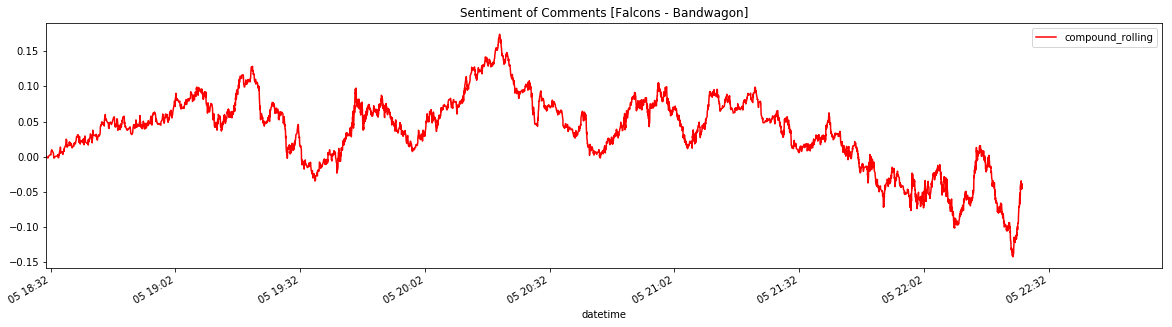

In [224]:
# Only Falcons Fans
df_falc_bandwagon = df_gametime.loc[df_gametime['author_flair_text'] == 'Falcons - Bandwagon']
#df_pats_only.plot(x='datetime', y='compound', figsize=(20,5))

df_falc_bandwagon['compound_rolling'] = pd.rolling_mean(df_falc_bandwagon['compound'], window=200)
df_falc_bandwagon.plot(x='datetime',
                       y='compound_rolling',
                       figsize=(20,5),
                       color='red',
                       title='Sentiment of Comments [Falcons - Bandwagon]')

In [238]:
df_gametime

,datetime,author,author_flair_text,id,parent_id,body,count,created_utc,ss,neg,neu,pos,compound,compound_rolling
2763,2017-02-05 22:59:59,angoosey8991,None,dddxxcd,t3_5sapal,Wew lads,1,1486353599,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN
2764,2017-02-05 22:59:58,DarrelleRevis24,Patriots,dddxxb8,t1_dddxtk4,He won 2 while on the giants coaching staff an...,1,1486353598,"{'neg': 0.0, 'neu': 0.751, 'pos': 0.249, 'comp...",0.000,0.751,0.249,0.7666,NaN
2765,2017-02-05 22:59:56,Dane713,Patriots,dddxx9d,t3_5sapal,"Wow, trying to decide which shirt to get.",1,1486353596,"{'neg': 0.0, 'neu': 0.648, 'pos': 0.352, 'comp...",0.000,0.648,0.352,0.5859,NaN
2766,2017-02-05 22:59:50,cyancynic,Broncos,dddxx3i,t1_dddxpw5,Saw on a church today: God will never abandon ...,1,1486353590,"{'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'comp...",0.000,0.689,0.311,0.5432,NaN
2767,2017-02-05 22:59:49,Hamiltonianc,Bears,dddxx3b,t1_dddxuui,"&gt;First, I think it's stupid that the game w...",1,1486353589,"{'neg': 0.049, 'neu': 0.751, 'pos': 0.199, 'co...",0.049,0.751,0.199,0.8860,NaN
2768,2017-02-05 22:59:48,nevalja,Cowboys - Bandwagon,dddxx1m,t1_dddxt7e,"Yeah, it just seems weird that you get the cha...",1,1486353588,"{'neg': 0.069, 'neu': 0.771, 'pos': 0.159, 'co...",0.069,0.771,0.159,0.1901,NaN
2769,2017-02-05 22:59:46,Newellium,None,dddxwzz,t3_5sapal,It was beautiful to see how much of a recovery...,1,1486353586,"{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...",0.000,0.809,0.191,0.6688,NaN
2770,2017-02-05 22:59:46,chihawks,Bears,dddxwz9,t3_5sapal,lets ride,1,1486353586,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,NaN
2771,2017-02-05 22:59:44,SergeantSquirrel,Vikings,dddxwxj,t3_5sapal,Drive safe everyone.,1,1486353584,"{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...",0.000,0.408,0.592,0.4404,NaN
2772,2017-02-05 22:59:44,daaaren,None,dddxwxg,t1_dddwu2b,Agreed. Godsend for the Pats that it was missed.,1,1486353584,"{'neg': 0.156, 'neu': 0.426, 'pos': 0.418, 'co...",0.156,0.426,0.418,0.5719,NaN
